# Cart2Text

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval
import numpy as np
from sklearn.metrics import mutual_info_score


def ConvPixel(FVec, xp, yp, A, B, base=1, custom_cut=None, index=0):
    n = len(FVec)
    M = np.ones([int(A), int(B)]) * base
    for j in range(0, n):
        # M[int(xp[j]) - 1, int(yp[j]) - 1] = 0
        M[int(xp[j]) - 1, int(yp[j]) - 1] = FVec[j]
    zp = np.array([xp, yp])

    # zp[:, 0] = zp[:, 12]
    # zp[:, 13] = zp[:, 0]
    # zp[:, 15] = zp[:, 0]
    #
    # zp[:,6] = zp[:, 5]
    # zp[:, 2] = zp[:, 6]
    # zp[:, 11] = zp[:, 6]

    dup = {}
    # find duplicate
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                # if i in dup.keys():
                # print("duplicate:" + str(i) + " " + str(j) + "value: ")
                # dup.add(i)
                # dup[i].add(j)
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
                # print("Collisione")

    # print("Collisioni:")
    # print(dup.keys())

    for index in dup.keys():
        x, y = index.split("-")
        M[int(float(x)) - 1, int(float(y)) - 1] = sum(FVec[list(dup[index])]) / len(dup[index])
    if custom_cut is not None:
      M = np.delete(M, range(0, custom_cut), 0)
    return M

import math
import pickle

import pandas as pd
import json as json
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import imageio

import numpy as np


def find_duplicate(zp):
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
    sum = 0
    for ind in dup.keys():
        sum = sum + (len(dup[ind]) - 1)
    return sum


def dataset_with_best_duplicates(X, y, zp):
    X = X.transpose()
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)

    # print("Collisioni:" + str(len(dup.keys())))
    # print(dup.keys())
    toDelete = []
    for index in dup.keys():
        mi = []
        x_new = X[:, list(dup[index])]
        mi = mutual_info_classif(x_new, y)
        max = np.argmax(mi)
        dup[index].remove(list(dup[index])[max])
        toDelete.extend(list(dup[index]))
    X = np.delete(X, toDelete, axis=1)
    zp = np.delete(zp, toDelete, axis=1)
    return X.transpose(), zp, toDelete

def count_model_col(rotatedData,Q,r1,r2):
    tot = []
    for f in range(r1-1, r2):
        A = f
        B = f
        xp = np.round(
            1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
        yp = np.round(
            1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
        zp = np.array([xp, yp])
        A = max(xp)
        B = max(yp)

        # find duplicates
        sum=str(find_duplicate(zp))
        print("Collisioni: " + sum)
        tot.append([A,sum])
        a = ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B)
        plt.imshow(a, cmap="gray")
        plt.savefig(str(A)+'.png')
        plt.show()
    pd.DataFrame(tot).to_csv("Collision_autoencoder.csv")


def Cart2Pixel(Q=None, A=None, B=None, dynamic_size=False, mutual_info=False, only_model=False, params=None):
    # TODO controls on input
    if A is not None:
        A = A - 1
    if (B != None):
        B = B - 1
    # to dataframe
    feat_cols = ["col-" + str(i + 1) for i in range(Q["data"].shape[1])]
    df = pd.DataFrame(Q["data"], columns=feat_cols)
    if Q["method"] == 'pca':
        pca = PCA(n_components=2)
        Y = pca.fit_transform(df)
    elif Q["method"] == 'tSNE':
        tsne = TSNE(n_components=2, method="exact")
        Y = tsne.fit_transform(df)
    elif Q["method"] == 'kpca':
        kpca = KernelPCA(n_components=2, kernel='linear')
        Y = kpca.fit_transform(df)

    x = Y[:, 0]
    y = Y[:, 1]
    n, n_sample = Q["data"].shape
    # plt.scatter(x, y)
    bbox = minimum_bounding_rectangle(Y)
    # plt.fill(bbox[:, 0], bbox[:, 1], alpha=0.2)
    # rotation
    grad = (bbox[1, 1] - bbox[0, 1]) / (bbox[1, 0] - bbox[0, 0])
    theta = np.arctan(grad)
    R = np.asmatrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    bboxMatrix = np.matrix(bbox)
    zrect = (R.dot(bboxMatrix.transpose())).transpose()
    # zrect=R.dot(bboxMatrix)
    # plt.fill(zrect[:, 0], zrect[:, 1], alpha=0.2)

    coord = np.array([x, y])
    rotatedData = np.array(R.dot(coord))  # Z

    # rotatedData = np.delete(rotatedData, [125], 1)
    # rotatedData=np.delete(rotatedData, [175],1)
    # rotatedData=np.delete(rotatedData, [184],1)
    # Q["data"] = np.delete(Q["data"], [125], axis=0)
    # Q["data"] = np.delete(Q["data"], [175], axis=0)
    # Q["data"] = np.delete(Q["data"], [184], axis=0)
    # n = n - 3
    plt.scatter(rotatedData[0, :], rotatedData[1:])
    plt.axis('square')
    plt.show(block=False)

    # find duplicate
    for i in range(len(rotatedData[0, :])):
        for j in range(i + 1, len(rotatedData[0])):
            if rotatedData[0, i] == rotatedData[0, j] and rotatedData[1, i] == rotatedData[1, j]:
                print("duplicate:" + str(i) + " " + str(j))

    # nearest point

    min_dist = np.inf
    min_p1 = 0
    min_p2 = 0
    for p1 in range(n):
        for p2 in range(p1 + 1, n):
            d = (rotatedData[0, p1] - rotatedData[0, p2]) ** 2 + (rotatedData[1, p1] - rotatedData[1, p2]) ** 2
            if min_dist > d > 0 and p1 != p2:
                min_p1 = p1
                min_p2 = p2
                min_dist = d
    # plt.scatter([rotatedData[0, min_p1], rotatedData[0, min_p2]], [rotatedData[1, min_p1], rotatedData[1, min_p2]])
    # plt.show(block=False)

    # euclidean distance
    dmin = np.linalg.norm(rotatedData[:, min_p1] - rotatedData[:, min_p2])
    rec_x_axis = abs(zrect[0, 0] - zrect[1, 0])
    rec_y_axis = abs(zrect[1, 1] - zrect[2, 1])

    #count_model_col(rotatedData,Q,5,20)

    if dynamic_size:
        precision_old = math.sqrt(2)
        A = math.ceil(rec_x_axis * precision_old / dmin)
        B = math.ceil(rec_y_axis * precision_old / dmin)
        print("Dynamic [A:" + str(A) + " ; B:" + str(B) + "]")
        if A > Q["max_A_size"] or B > Q["max_B_size"]:
            # precision = precision_old * Q["max_px_size"] / max([A, B])
            precision = precision_old * (Q["max_A_size"] / A) * (Q["max_B_size"] / B)
            A = math.ceil(rec_x_axis * precision / dmin)
            B = math.ceil(rec_y_axis * precision / dmin)
    # cartesian coordinates to pixels
    tot = []
    xp = np.round(
        1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
    yp = np.round(
        1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
    # Modified Feature Position | custom cut
    cut = params["cut"]
    if cut is not None:
      assert True
      xp[59] = cut

    zp = np.array([xp, yp])
    A = max(xp)
    B = max(yp)

    # find duplicates
    print("Collisioni: " + str(find_duplicate(zp)))


    # Training set

    images = []
    toDelete = 0
    name = "_" + str(int(A)) + 'x' + str(int(B))
    if params["No_0_MI"]:
        name = name + "_No_0_MI"
    if mutual_info:
        print("calc MI")
        Q["data"], zp, toDelete = dataset_with_best_duplicates(Q["data"], Q["y"], zp)
        name = name + "_MI"
        print("MI done")


    else:
        name = name + "_Mean"
    if cut is not None:
        name = name + "_Cut"+str(cut)
    if only_model:
        a = ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B)
        plt.imshow(a, cmap="gray")
        plt.show()
    else:
        a=ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B, index=i)
        plt.imshow(a,cmap="gray")
        plt.show()
        print("Create images")
        if cut is not None:
          images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B, custom_cut=cut-1, index=i) for i in range(0, n_sample)]
        else:
          images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B, index=i) for i in range(0, n_sample)]

        filename = params["dir"] + "train" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(images, f_myfile)
        f_myfile.close()
        filename = params["res"] + "train" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(images, f_myfile)
        f_myfile.close()

    feature_mapping = {
        'pixel_mapping': {},
        'feature_names': list(Q["data"].columns) if hasattr(Q["data"], 'columns') else feat_cols  # Using feat_cols from earlier
    }
    
    for i, (x, y) in enumerate(zip(xp, yp)):
        pixel_idx = (int(y) - 1) * int(A) + (int(x) - 1)
        feature_mapping['pixel_mapping'][pixel_idx] = {
            'feature_name': feature_mapping['feature_names'][i] if feature_mapping['feature_names'] else f'Feature_{i}',
            'x_coord': int(x),
            'y_coord': int(y)
        }

    # Replace the existing image_model creation with this:
    image_model = {
        "xp": zp[0].tolist(), 
        "yp": zp[1].tolist(), 
        "A": A, 
        "B": B, 
        "custom_cut": cut,
        "feature_mapping": feature_mapping
    }


    return images, image_model, toDelete


# Neural

In [15]:
import numpy as np
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add, \
    Concatenate, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def CNN_Nature(images, y, param=None):
    print(param)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100)
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])

    num_filters = param["filter"]
    num_filters2 = param["filter2"]

    kernel = param["kernel"]
    # Get number of classes from the shape of y
    num_classes = y.shape[1] if len(y.shape) > 1 else len(np.unique(y))
    inputs = Input(shape=(image_size, image_size2, 1))
    print(x_train.shape)
    out = Conv2D(filters=num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=2 * num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=4 * num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    # layer 2
    out2 = Conv2D(filters=num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(inputs)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=2 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=4 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)

    # final layer
    outf = Concatenate()([out, out2])
    out_f = AveragePooling2D(strides=2, pool_size=2)(outf)
    out_f = Flatten()(out_f)
    predictions = Dense(num_classes, activation='softmax')(out_f)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)

    adam = Adam(lr=param["learning_rate"])

    # Compile the model.
    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=param["epoch"],
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=param["batch"],
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10),
                   ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.keras')

    y_test_classes = np.argmax(y_test, axis=1)
    Y_predicted = model.predict(x_test, verbose=0)
    Y_predicted_classes = np.argmax(Y_predicted, axis=1)
    metrics = {
        "balanced_accuracy_val": balanced_accuracy_score(y_test_classes, Y_predicted_classes) * 100,
        "weighted_f1_val": f1_score(y_test_classes, Y_predicted_classes, average='weighted') * 100
    }
    
    if num_classes == 2:
        cf = confusion_matrix(y_test_classes, Y_predicted_classes)
        metrics.update({
            "TP_val": cf[0][0],
            "FN_val": cf[0][1],
            "FP_val": cf[1][0],
            "TN_val": cf[1][1]
        })
    else:
        cf = confusion_matrix(y_test_classes, Y_predicted_classes)
        metrics["confusion_matrix"] = cf.tolist()

    return model, metrics
    

    

def CNN2(images, y, params=None):
    print(params)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100
                                                        )
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])


    kernel = params["kernel"]
    kernel2=int(kernel/2)
    inputs = Input(shape=(image_size, image_size2, 1))
    num_classes = y.shape[1] if len(y.shape) > 1 else len(np.unique(y))
    X = Conv2D(32, (kernel,kernel), activation='relu', name='conv0')(inputs)
    X = Dropout(rate=params['dropout1'])(X)
    X = Conv2D(64, (kernel, kernel), activation='relu', name='conv1')(X)
    X = Dropout(rate=params['dropout2'])(X)
    X = Conv2D(128, (kernel, kernel), activation='relu', name='conv2')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(X)

    model = Model(inputs, X)
    adam = Adam(params["learning_rate"])

    model.compile(loss='categorical_crossentropy',  # Changed from 'binary_crossentropy'
        optimizer=adam,
        metrics=['accuracy'])

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=params["epoch"],
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=params["batch"],
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10),
                   ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.keras')

    y_test_classes= np.argmax(y_test, axis=1)

    Y_predicted = model.predict(x_test, verbose=0)

    Y_predicted_classes = np.argmax(Y_predicted, axis=1)

    cf = confusion_matrix(y_test, Y_predicted)

    metrics = {
        "balanced_accuracy_val": balanced_accuracy_score(y_test_classes, Y_predicted_classes) * 100,
        "weighted_f1_val": f1_score(y_test_classes, Y_predicted_classes, average='weighted') * 100
    }
    if num_classes == 2:
        cf = confusion_matrix(y_test_classes, Y_predicted_classes)
        metrics.update({
            "TP_val": cf[0][0],
            "FN_val": cf[0][1],
            "FP_val": cf[1][0],
            "TN_val": cf[1][1]
        })
    else:
        cf = confusion_matrix(y_test_classes, Y_predicted_classes)
        metrics["confusion_matrix"] = cf.tolist()

    return model, metrics

# Train

In [16]:
import csv
import json
import pickle
import timeit
import numpy as np
from hyperopt import STATUS_OK
from hyperopt import tpe, hp, Trials, fmin
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
# Added f1_score for multiclass metrics
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score
import time

XGlobal = []
YGlobal = []
XTestGlobal = []
YTestGlobal = []
SavedParameters = []
Mode = ""
Name = ""
best_val_acc = 0
path_model = ""

def fix(f):
    # No changes needed here - this is for binary classification
    a = f["TN_val"]
    b = f["FP_val"]
    c = f["FN_val"]
    d = f["TP_val"]
    f["TN_val"] = d
    f["TP_val"] = a
    f["FP_val"] = c
    f["FN_val"] = b
    return f

def fix_test(f):
    # No changes needed here - this is for binary classification
    a = f["TN_test"]
    b = f["FP_test"]
    c = f["FN_test"]
    d = f["TP_test"]
    f["TN_test"] = d
    f["TP_test"] = a
    f["FP_test"] = c
    f["FN_test"] = b
    return f

def res(cm, val):
    # This function remains unchanged as it's only used for binary classification
    tp = cm[0][0]  # attacks true
    fn = cm[0][1]  # attacs predict normal
    fp = cm[1][0]  # normal predict attacks
    tn = cm[1][1]  # normal as normal
    attacks = tp + fn
    normals = fp + tn
    print(attacks)
    print(normals)

    if attacks <= normals:
        print("ok")
    elif not val:
        print("error")
        return False, False
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / attacks) + (tn / normals)) / 2
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [OA, AA, P, R, F1, FAR, TPR]
    return True, r

def hyperopt_fcn(params):
    if Mode == "CNN_Nature":
        if params["filter"] == params["filter2"]:
            return {'loss': np.inf, 'status': STATUS_OK}
    
    global SavedParameters
    start_time = time.time()
    print("start train")
    
    if Mode == "CNN_Nature":
        model, val = CNN_Nature(XGlobal, YGlobal, params)
    elif Mode == "CNN2":
        model, val = CNN2(XGlobal, YGlobal, params)
    
    print("start predict")
    print(XTestGlobal.shape)
    print(YTestGlobal.shape)
    
    Y_predicted = model.predict(XTestGlobal, verbose=0)
    Y_predicted = np.argmax(Y_predicted, axis=1)
    elapsed_time = time.time() - start_time
    cf = confusion_matrix(YTestGlobal, Y_predicted)
    
    K.clear_session()
    SavedParameters.append(val)
    global best_val_acc

    # Added detection of number of classes
    num_classes = len(np.unique(YTestGlobal))

    if num_classes == 2:
        # Original binary classification code
        if Mode == "CNN_Nature":
            SavedParameters[-1].update({
                "balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100,
                "TP_test": cf[0][0], "FN_test": cf[0][1],
                "FP_test": cf[1][0], "TN_test": cf[1][1],
                "kernel": params["kernel"],
                "learning_rate": params["learning_rate"],
                "batch": params["batch"],
                "filter1": params["filter"],
                "filter2": params["filter2"],
                "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            })
        elif Mode == "CNN2":
            SavedParameters[-1].update({
                "balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100,
                "TN_test": cf[0][0], "FP_test": cf[0][1],
                "FN_test": cf[1][0], "TP_test": cf[1][1],
                "kernel": params["kernel"],
                "learning_rate": params["learning_rate"],
                "batch": params["batch"],
                "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            })

        # Original binary metrics calculation
        cm_val = [[SavedParameters[-1]["TP_val"], SavedParameters[-1]["FN_val"]],
                 [SavedParameters[-1]["FP_val"], SavedParameters[-1]["TN_val"]]]
        done, r = res(cm_val, True)
        if not done:
            SavedParameters[-1] = fix(SavedParameters[-1])
            cm_val = [[SavedParameters[-1]["TP_val"], SavedParameters[-1]["FN_val"]],
                     [SavedParameters[-1]["FP_val"], SavedParameters[-1]["TN_val"]]]
            done, r = res(cm_val, True)
        assert done == True
        SavedParameters[-1].update({
            "OA_val": r[0],
            "P_val": r[2],
            "R_val": r[3],
            "F1_val": r[4],
            "FAR_val": r[5],
            "TPR_val": r[6]
        })

        cm_test = [[SavedParameters[-1]["TP_test"], SavedParameters[-1]["FN_test"]],
                   [SavedParameters[-1]["FP_test"], SavedParameters[-1]["TN_test"]]]
        done, r = res(cm_test, False)
        if not done:
            SavedParameters[-1] = fix_test(SavedParameters[-1])
            cm_test = [[SavedParameters[-1]["TP_test"], SavedParameters[-1]["FN_test"]],
                      [SavedParameters[-1]["FP_test"], SavedParameters[-1]["TN_test"]]]
            done, r = res(cm_test, False)
        assert done == True

        SavedParameters[-1].update({
            "OA_test": r[0],
            "P_test": r[2],
            "R_test": r[3],
            "F1_test": r[4],
            "FAR_test": r[5],
            "TPR_test": r[6]
        })
    else:
        # New multiclass metrics calculation
        SavedParameters[-1].update({
            "balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100,
            "weighted_f1_test": f1_score(YTestGlobal, Y_predicted, average='weighted') * 100,
            "confusion_matrix_test": cf.tolist(),
            "kernel": params["kernel"],
            "learning_rate": params["learning_rate"],
            "batch": params["batch"],
            "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        })

        if Mode == "CNN_Nature":
            SavedParameters[-1].update({
                "filter1": params["filter"],
                "filter2": params["filter2"]
            })

    # Modified model saving criterion
    if num_classes == 2:
        if SavedParameters[-1]["F1_val"] > best_val_acc:
            print("new saved model:" + str(SavedParameters[-1]))
            model.save(path_model)
            best_val_acc = SavedParameters[-1]["F1_val"]
    else:
        if SavedParameters[-1]["weighted_f1_val"] > best_val_acc:
            print("new saved model:" + str(SavedParameters[-1]))
            model.save(path_model)
            best_val_acc = SavedParameters[-1]["weighted_f1_val"]

    # Modified sorting criterion
    if num_classes == 2:
        SavedParameters = sorted(SavedParameters, key=lambda i: i['F1_test'], reverse=True)
    else:
        SavedParameters = sorted(SavedParameters, key=lambda i: i['weighted_f1_test'], reverse=True)

    try:
        with open(Name, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=SavedParameters[0].keys())
            writer.writeheader()
            writer.writerows(SavedParameters)
    except IOError:
        print("I/O error")

    return {'loss': -val["F1_test" if num_classes == 2 else "weighted_f1_test"], 'status': STATUS_OK}

def train_norm(param, dataset, norm):
    np.random.seed(param["seed"])
    print("modelling dataset")
    global YGlobal
    YGlobal = to_categorical(dataset["Classification"])
    del dataset["Classification"]
    global YTestGlobal
    YTestGlobal = to_categorical(dataset["Ytest"])
    del dataset["Ytest"]

    global XGlobal
    global XTestGlobal

    # Rest of the function remains unchanged until optimizable_variable definition

    # Modified optimizable variables to include number of classes
    if param["Mode"] == "CNN_Nature":
        optimizable_variable = {
            "kernel": hp.choice("kernel", np.arange(2, 4 + 1)),
            "filter": hp.choice("filter", [16, 32, 64, 128]),
            "filter2": hp.choice("filter2", [16, 32, 64, 128]),
            "batch": hp.choice("batch", [16]),
            "learning_rate": hp.uniform("learning_rate", 0.0001, 0.01),
            "epoch": param["epoch"]
        }
    elif param["Mode"] == "CNN2":
        optimizable_variable = {
            "kernel": hp.choice("kernel", np.arange(2, 4 + 1)),
            "batch": hp.choice("batch", [32, 64, 128, 256, 512]),
            'dropout1': hp.uniform("dropout1", 0, 1),
            'dropout2': hp.uniform("dropout2", 0, 1),
            "learning_rate": hp.uniform("learning_rate", 0.0001, 0.001),
            "epoch": param["epoch"]
        }

    # Rest of the function remains unchanged
    global Mode
    Mode = param["Mode"]

    global Name
    Name = param["res"] + "res_" + str(int(param["Max_A_Size"])) + "x" + str(int(param["Max_B_Size"]))
    if param["No_0_MI"]:
        Name = Name + "_No_0_MI"
    if param["mutual_info"]:
        Name = Name + "_MI"
    else:
        Name = Name + "_Mean"
    Name = Name + "_" + Mode + ".csv"

    global path_model
    path_model = Name.replace(".csv", "_model.h5")

    trials = Trials()
    fmin(hyperopt_fcn, optimizable_variable, trials=trials, algo=tpe.suggest, max_evals=param["hyper_opt_evals"])

    print("done")
    return 1

# Load Files


# ACGAN


In [13]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
# from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
session = tf.compat.v1.InteractiveSession(config=config)

pathModel='D:/IDS/Datasets/AAGM/acgan_aagm.h5'
generator = load_model(pathModel, compile=False) # Disable compilation during loading

param = {"Max_A_Size": 10, "Max_B_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE', "ValidRatio": 0.1, "seed": 180,
             "dir": "D:/IDS/Datasets/AAGM/", "Mode": "CNN2",  # Mode : CNN_Nature, CNN2
             "LoadFromJson": False, "mutual_info": True,  # Mean or MI
             "hyper_opt_evals": 20, "epoch": 150, "No_0_MI": False,  # True -> Removing 0 MI Features
             "autoencoder": False, "cut": None
             }
dim=53330
images = {}
if param['mutual_info']:
    method = 'MI'
else:
    method = 'Mean'
f_myfile = open(param["dir"] + 'train_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+method+'.pickle', 'rb')
images["Xtrain"] = pickle.load(f_myfile)
f_myfile.close()

f_myfile = open(param["dir"] + 'YTrain.pickle', 'rb')
images["Classification"] = pickle.load(f_myfile)
(x_train, y_train) = np.asarray(images["Xtrain"]), np.asarray(images["Classification"])
print(x_train.shape)


print(y_train.shape)

noise_input = np.random.uniform(-1.0, 1.0, size=[dim, 100]) #se 1 produce 1 sola immagine
#AGAN#

class_label=1
noise_label = np.ones((dim, 2))
noise_label[:,class_label] = 1
step = class_label
noise_input = [noise_input, noise_label]

#AGAN
generator.summary()
predictions = generator.predict(noise_input)
predictions=tf.reshape(predictions,[dim,10,10])

print(1, type(images["Xtrain"]))
print(2, type(predictions.numpy().tolist()))
new = predictions.numpy().tolist()
print(len(new))
images["Xtrain"].extend(new)
print(4, type(images["Classification"].tolist()))
print(4, type(list(np.zeros(dim))))
images["Classification"] = pd.concat([images["Classification"], pd.Series(np.ones(dim))], ignore_index=True)
print(len(images['Xtrain']))

f_myfile = open(param["dir"] + 'XTrain50A%.pickle', 'wb')
pickle.dump(images["Xtrain"], f_myfile)
f_myfile.close()

f_myfile = open(param["dir"] + 'YTrain50A%.pickle', 'wb')
pickle.dump(images["Classification"], f_myfile)
f_myfile.close()




(494021, 10, 10)
(494021,)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_input             │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 102)       │          0 │ z_input[0][0],    │
│ (Concatenate)       │                   │            │ labels[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6400)      │    659,200 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5, 256) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 5, 256) │      1,024 │ reshape[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 5, 5, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 10, 10,    │  1,638,656 │ activation_1[0][… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 10, 10,    │    819,328 │ activation_2[0][… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 10, 10,    │    204,864 │ activation_3[0][… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 10, 10,    │     51,232 │ activation_4[0][… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_transpose

 Total params: 3,377,025 (12.88 MB)

 Trainable params: 3,375,553 (12.88 MB)

 Non-trainable params: 1,472 (5.75 KB)

1667/1667 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step
1 <class 'list'>
2 <class 'list'>
53330
4 <class 'list'>
4 <class 'list'>
547351


# Main


In [ ]:
pip uninstall pandas

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/pandas-2.2.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/pandas/*
Proceed (Y/n)? y
  Successfully uninstalled pandas-2.2.2


In [ ]:
!pip install pandas==1.3.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas: filename=pandas-1.3.5-cp311-cp311-linux_x86_64.whl size=37464003 sha256=a4c212cf8033d56a6fc6e03a856a1a73a0f13cb035774263c582e750e90b423f
  Stored in directory: /root/.cache/pip/wheels/8b/e7/6d/d4c288f419ab8fa07c1db6f606a2ae18ecf3dc2839d79a1c07
Successfully built pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.3.5 which is incompatible.
arviz 0.20.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which 

In [2]:
import json
import os
from cicids_preprocessing import load_cicids_data
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pickle

from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE, ADASYN

import pandas as pd
import csv
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Parameters
param = {"Max_A_Size": 10, "Max_B_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE', "ValidRatio": 0.1,"Dynamic_size":False, "seed": 180,
          "dir": "D:/IDS/Datasets/", "Mode": "CNN2",  # Mode : CNN_Nature, CNN2    | DIR: local working directory
          "res":"D:/IDS/Results/",#remote path for saving data
          "LoadFromJson": False, "mutual_info": True, # LoadFromJson: True: load pickle files (images)
          #MOVE Ytrain.pickle and Ytest.pickle to the working directory after generating the images
          "hyper_opt_evals": 20, "epoch": 150, "No_0_MI": False,  # True -> Removing 0 MI Features
          "autoencoder": False,  "cut": None,"enhanced_dataset":None,"multiclass":True # gan, smote, adasyn, ""None""
          }

if not param["LoadFromJson"]:
    dataset, feature_list, label_encoder = load_cicids_data(
        param["dir"] + "cicids_dataset.csv",
        multiclass=param["multiclass"]
    )

dataset = 3  # change dataset
if dataset == 1:
    train = 'TrainOneCls.csv'
    test = 'Test.csv'
    classif_label = 'Classification'
    param["attack_label"] = 0
elif dataset == 2:
    train = 'Train.csv'
    test = 'Test_UNSW_NB15.csv'
    classif_label = 'classification'
    param["attack_label"] = 1
elif dataset == 3:
    train = 'Train.csv'
    test = 'Test.csv'
    classif_label = ' classification.'
    param["attack_label"] = 1
elif dataset == 4:
    train = 'AAGMTrain_OneClsNumeric.csv'
    test = 'AAGMTest_OneClsNumeric.csv'
    classif_label = 'classification'
    param["attack_label"] = 0


if not param["LoadFromJson"]:
    data = {}
    with open(param["dir"] + train, 'r') as file:
        data = {"Xtrain": pd.DataFrame(list(csv.DictReader(file))).apply(pd.to_numeric, errors='coerce'), "class": 2}
        data["Classification"] = data["Xtrain"][classif_label]
        del data["Xtrain"][classif_label]
    with open(param["dir"]+test, 'r') as file:
        Xtest = pd.DataFrame(list(csv.DictReader(file)))
        #Xtest.drop(Xtest.keys()[0], axis=1)
        Xtest.replace("", np.nan, inplace=True)
        Xtest.dropna(inplace=True)
        data["Xtest"] = Xtest[Xtest.keys()[1:]].apply(pd.to_numeric, errors='coerce')
        data["Ytest"] = data["Xtest"][classif_label]
        del data["Xtest"][classif_label]

        filename = "work/Ytrain.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(data["Classification"], f_myfile)
        f_myfile.close()
        filename = "Ytest.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(data["Ytest"], f_myfile, protocol=pickle.HIGHEST_PROTOCOL)
        f_myfile.close()

        if param["enhanced_dataset"] == "smote":
          sm = SMOTE(random_state=42)
          data["Xtrain"], data["Classification"] = sm.fit_resample(data["Xtrain"], data["Classification"])
        elif param["enhanced_dataset"] == "adasyn":
          ada = ADASYN(random_state=42)
          data["Xtrain"], data["Classification"] = ada.fit_resample(data["Xtrain"], data["Classification"])


     # AUTOENCODER
    if param["autoencoder"]:
        autoencoder = load_model(param["dir"] + 'Autoencoder.h5')
        autoencoder.summary()
        encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encod2').output)
        encoder.summary()
        # usa l'encoder con predict sul train_X e poi su test_X. Io qui ho creato anche il dataframe per salvarlo poi come csv
        encoded_train = pd.DataFrame(encoder.predict(data["Xtrain"]))
        data["Xtrain"] = encoded_train.add_prefix('feature_')
        encoded_test = pd.DataFrame(encoder.predict(data["Xtest"]))
        data["Xtest"] = encoded_test.add_prefix('feature_')


    model = train_norm(param, data, norm=False)

else:
    images = {}
    if param['mutual_info']:
        method = 'MI'
    else:
        method = 'Mean'

    f_myfile = open(param["dir"] + 'train_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+method+'.pickle', 'rb')
    images["Xtrain"] = pickle.load(f_myfile)
    f_myfile.close()

    f_myfile = open(param["dir"] + 'YTrain.pickle', 'rb')
    images["Classification"] = pickle.load(f_myfile)
    f_myfile.close()

    f_myfile = open(param["dir"] + 'test_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+method+'.pickle', 'rb')
    images["Xtest"] = pickle.load(f_myfile)
    f_myfile.close()

    f_myfile = open(param["dir"] + 'YTest.pickle', 'rb')
    images["Ytest"] = pd.read_pickle(f_myfile)
    f_myfile.close()

    if param["enhanced_dataset"] == "gan":

        new=predictions.numpy()
        print(len(new))
        images["Xtrain"].extend(new)
        print(len(images["Xtrain"]))

        images["Classification"]=images["Classification"].add(pd.Series(np.ones(dim)))
        #.append(list(np.zeros(dim)))
        #print(images["Xtrain"])

    #print(4,len(images["Ytest"]))
    filename = param["res"] + "trainGAN.pickle"
    f_myfile = open(filename, 'wb')
    pickle.dump(images, f_myfile)
    f_myfile.close()

    model = train_norm(param, images, norm=False)


Loading CICIDS dataset...
Dataset loaded: 729789 training samples, 312768 test samples
Number of classes: 4
Features: 78
Class distribution: 
BENIGN: 440351 train, 188723 test
DDoS: 89616 train, 38406 test
DoS: 136249 train, 58393 test
PortScan: 63573 train, 27246 test


KeyError: ' classification.'

Loading trained model...
Model loaded successfully.
Attempting to load preprocessed test data...
Preprocessed test data loaded successfully.
Preparing test data for prediction...
Making predictions on test data...
9720/9720 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
Evaluating predictions...
Balanced Accuracy: 94.94%
Confusion Matrix:
[[229295  21141]
 [  1016  59577]]

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.92      0.95    250436
      Attack       0.74      0.98      0.84     60593

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029

Generating SHAP explanations...


d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_20
Received: inputs=['Tensor(shape=(1, 10, 10, 1))']
  warnings.warn(msg)
d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_20
Received: inputs=['Tensor(shape=(50, 10, 10, 1))']
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Detailed Explanation for the Selected Sample:
Predicted Class: Normal
Prediction Probabilities: [[1. 0.]]
Expected Values (Average Prediction): [1.3500002e-04 9.9986494e-01]


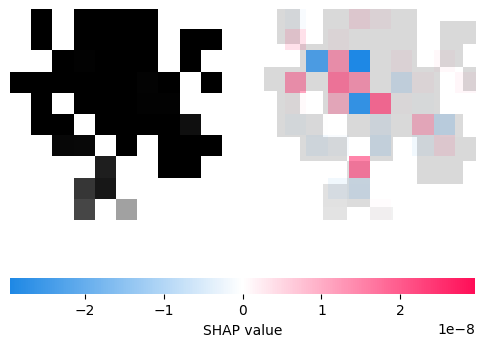


Top Positive Contributions:
Pixel_70: 0.1400
Pixel_48: 0.1228
Pixel_114: 0.0777
Pixel_154: 0.0761
Pixel_44: 0.0721
Pixel_112: 0.0678
Pixel_148: 0.0595
Pixel_168: 0.0518
Pixel_66: 0.0511
Pixel_88: 0.0487

Top Negative Contributions:
Pixel_71: -0.1400
Pixel_49: -0.1228
Pixel_115: -0.0777
Pixel_155: -0.0761
Pixel_45: -0.0721
Pixel_113: -0.0678
Pixel_149: -0.0595
Pixel_169: -0.0518
Pixel_67: -0.0511
Pixel_89: -0.0487


Force plot saved at: D:/IDS/force_plot.html


In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
import shap
import matplotlib.pyplot as plt

# Parameters
param = {
    "Max_A_Size": 10,
    "Max_B_Size": 10,
    "Dynamic_Size": False,
    'Metod': 'tSNE',
    "ValidRatio": 0.1,
    "seed": 180,
    "dir": "D:/IDS/Datasets/",  # Directory for input files
    "res": "D:/IDS/Results/",  # Directory for output results
    "Mode": "CNN2",  # Model type
    "LoadFromJson": True,  # Whether to load preprocessed images
    "mutual_info": True,  # Method: Mutual Information (True) or Mean (False)
    "hyper_opt_evals": 20,
    "epoch": 150,
    "No_0_MI": False,  # Whether to remove features with 0 MI
    "autoencoder": False,
    "cut": None,
    "enhanced_dataset": None  # Options: 'gan', 'smote', 'adasyn', None
}

# Set paths
best_model_path = "D:/IDS/Datasets/AAGM/best_model.keras"  # Path to the trained model
test_pickle_path = param["dir"] + f'test_{param["Max_A_Size"]}x{param["Max_B_Size"]}_{"MI" if param["mutual_info"] else "Mean"}.pickle'
test_labels_path = param["dir"] + "YTest.pickle"

# Load Model
print("Loading trained model...")
model = load_model(best_model_path)
print("Model loaded successfully.")

# Check for preprocessed test data
try:
    print("Attempting to load preprocessed test data...")
    with open(test_pickle_path, 'rb') as f:
        XTestGlobal = pickle.load(f)
    with open(test_labels_path, 'rb') as f:
        YTestGlobal = pd.read_pickle(f)
    XTestGlobal = np.array(XTestGlobal)
    print("Preprocessed test data loaded successfully.")
except FileNotFoundError:

    print("Preprocessed test data not found. Regenerating from raw test.csv...")

    # Load raw test data
    test_csv_path = param["dir"] + "Test.csv"
    test_data = pd.read_csv(test_csv_path)
    test_data.replace("", np.nan, inplace=True)
    test_data.dropna(inplace=True)

    # Extract labels and features
    YTestGlobal = test_data[" classification."].astype(int)
    del test_data[" classification."]
    XTestGlobal_raw = test_data.values

    # Normalize if needed
    print("Normalizing test data...")
    test_max, test_min = XTestGlobal_raw.max(), XTestGlobal_raw.min()
    XTestGlobal_raw = (XTestGlobal_raw - test_min) / (test_max - test_min)

    # Reshape using Cart2Pixel or ConvPixel
    print("Generating 2D images from raw test data...")
    # Assuming `Cart2Pixel` function is defined elsewhere
    # Example: Replace with your actual implementation
    _, image_model, toDelete = Cart2Pixel(
        {"data": XTestGlobal_raw.T, "method": param["Metod"], "max_A_size": param["Max_A_Size"], "max_B_size": param["Max_B_Size"]},
        param["Max_A_Size"],
        param["Max_B_Size"],
        param["Dynamic_Size"],
        mutual_info=param["mutual_info"],
        params=param
    )

    XTestGlobal = [
        ConvPixel(
            XTestGlobal_raw[:, i],
            np.array(image_model["xp"]),
            np.array(image_model["yp"]),
            image_model["A"],
            image_model["B"],
            custom_cut=image_model["custom_cut"] if image_model["custom_cut"] else None
        ) for i in range(XTestGlobal_raw.shape[1])
    ]
    XTestGlobal = np.array(XTestGlobal)

    # Save preprocessed test data for future use
    print("Saving preprocessed test data...")
    with open(test_pickle_path, 'wb') as f:
        pickle.dump(XTestGlobal, f)
    with open(test_labels_path, 'wb') as f:
        pickle.dump(YTestGlobal, f)

# Reshape test data for the model
print("Preparing test data for prediction...")

image_size1, image_size2 = XTestGlobal.shape[1], XTestGlobal.shape[2]
XTestGlobal = np.reshape(XTestGlobal, (-1, image_size1, image_size2, 1))

# Predict using the trained model
print("Making predictions on test data...")
Y_predicted_probs = model.predict(XTestGlobal, verbose=1)
Y_predicted = np.argmax(Y_predicted_probs, axis=1)

# Evaluate the results
print("Evaluating predictions...")
accuracy = balanced_accuracy_score(YTestGlobal, Y_predicted)
conf_matrix = confusion_matrix(YTestGlobal, Y_predicted)
print(f"Balanced Accuracy: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")

report = classification_report(YTestGlobal, Y_predicted, target_names=["Normal", "Attack"])

print("\nClassification Report:\n", report)

# Create a SHAP explainer for the CNN model
# explainer_image = shap.Explainer(model, XTestGlobal)

# # Generate SHAP values
# shap_values_image = explainer_image(XTestGlobal)

# # Visualize SHAP summary
# Create a SHAP explainer for the CNN model
print("Generating SHAP explanations...")
# background = XTestGlobal.mean(axis=0, keepdims=True)  # Use mean as the background
# explainer_image = shap.GradientExplainer(model, background)

# # Select a sample
# sample_index = np.random.choice(len(XTestGlobal), 1, replace=False)[0]
# X_sample = XTestGlobal[sample_index:sample_index + 1]

# # Predict the class for the selected sample
# sample_pred_probs = model.predict(X_sample)[0]
# sample_pred_class = np.argmax(sample_pred_probs)

# # Generate SHAP values
# shap_values_image = explainer_image.shap_values(X_sample)

# # Check SHAP values structure
# if isinstance(shap_values_image, list) and len(shap_values_image) > 1:
#     class_shap_values = shap_values_image[sample_pred_class]
# else:
#     class_shap_values = shap_values_image[0]  # For single-class or regression

# class_shap_values = np.reshape(class_shap_values, X_sample.shape)


# # Display prediction and SHAP explanation
# print("\nDetailed Explanation for the Selected Sample:")
# print(f"Predicted Class: {'Normal' if sample_pred_class == 0 else 'Attack'}")
# print(f"Prediction Probabilities: {sample_pred_probs}")
# print(f"Baseline Prediction (Background Average): {baseline_pred}")

# # Visualize SHAP explanation
# print(f"\nSHAP Explanation for Sample {sample_index} (Predicted Class: {sample_pred_class}):")
# shap.image_plot([class_shap_values], X_sample)

# # Generate force plot
# shap.initjs()
# force_plot_path = "/content/IDS/force_plot.html"

# # Flatten SHAP values for the force plot
# flattened_features = X_sample.flatten()
# flattened_shap_values = class_shap_values.flatten()

# if flattened_features.shape != flattened_shap_values.shape:
#     raise ValueError(
#         f"Shape mismatch: features={flattened_features.shape}, shap_values={flattened_shap_values.shape}"
#     )

# # Generate force plot and save as HTML
# shap.save_html(
#     force_plot_path,
#     shap.force_plot(
#         sample_pred_probs[sample_pred_class],
#         flattened_shap_values,
#         flattened_features,
#         feature_names=[f"Pixel_{i}" for i in range(flattened_features.size)],
#         matplotlib=True
#     )
# )

# print(f"Force plot saved at: {force_plot_path}")

background = XTestGlobal[:100]  # Use the first 100 samples as the background
explainer_image = shap.GradientExplainer(model, background)

# Select a random sample for detailed explanation
random_idx = np.random.choice(XTestGlobal.shape[0], 1, replace=False)
X_sample = XTestGlobal[random_idx]
sample_pred_probs = Y_predicted_probs[random_idx]

sample_pred_class = Y_predicted[random_idx][0]


# Generate SHAP values
shap_values_image = explainer_image.shap_values(X_sample)

# sample_pred_class = np.clip(sample_pred_class, 0, len(shap_values_image) - 1)

# Compute expected values manually (average prediction over the background dataset)
expected_values = np.mean(model.predict(background), axis=0)

# Print detailed explanation for the selected sample
print("\nDetailed Explanation for the Selected Sample:")
print(f"Predicted Class: {'Normal' if sample_pred_class == 0 else 'Attack'}")
print(f"Prediction Probabilities: {sample_pred_probs}")
print(f"Expected Values (Average Prediction): {expected_values}")

# Visualize SHAP explanation
shap.image_plot(shap_values_image, X_sample)

positive_contributions = []
negative_contributions = []

shap_values_flat = shap_values_image[0].flatten()
for i, value in enumerate(shap_values_flat):
    feature = f"Pixel_{i}"
    if value > 0:
        positive_contributions.append((feature, value))
    else:
        negative_contributions.append((feature, value))

positive_contributions = sorted(positive_contributions, key=lambda x: x[1], reverse=True)
negative_contributions = sorted(negative_contributions, key=lambda x: x[1])

print("\nTop Positive Contributions:")
for feature, value in positive_contributions[:10]:
    print(f"{feature}: {value:.4f}")

print("\nTop Negative Contributions:")
for feature, value in negative_contributions[:10]:
    print(f"{feature}: {value:.4f}")

# Generate a summary force plot using SHAP (manually compute contributions)
shap.initjs()
force_plot_path = "D:/IDS/force_plot.html"

# shap_values_for_class = shap_values_image[sample_pred_class]
shap_values_for_class = shap_values_image[0, :, :, :, sample_pred_class]  # Accessing the correct class SHAP values
shap_values_for_class = shap_values_for_class.reshape(1, -1) # Reshape SHAP values to 2D

# Reshape X_sample to 2D to match SHAP values
X_sample_reshaped = X_sample.reshape(1, -1)

shap.save_html(
    force_plot_path,
    shap.force_plot(
        expected_values[sample_pred_class],  # Use the expected value for the predicted class
        shap_values_for_class[0],  # Use the first sample's SHAP values for the class
        X_sample_reshaped[0],  # Flattened input for visualization
        feature_names=["Pixel_" + str(i) for i in range(X_sample[0].size)]
    )
)

print(f"Force plot saved at: {force_plot_path}")

XAI Main


XAI
Beta version


9720/9720 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
X_sample shape: (1, 10, 10, 1)


d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_20
Received: inputs=['Tensor(shape=(1, 10, 10, 1))']
  warnings.warn(msg)
d:\IDS\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_20
Received: inputs=['Tensor(shape=(50, 10, 10, 1))']
  warnings.warn(msg)


Generated SHAP values shape: (1, 10, 10, 1, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Original SHAP values shape: (1, 10, 10, 1, 2)
Original sample shape: (1, 10, 10, 1)
Reshaped SHAP values shape: (100,)
Reshaped sample shape: (100,)


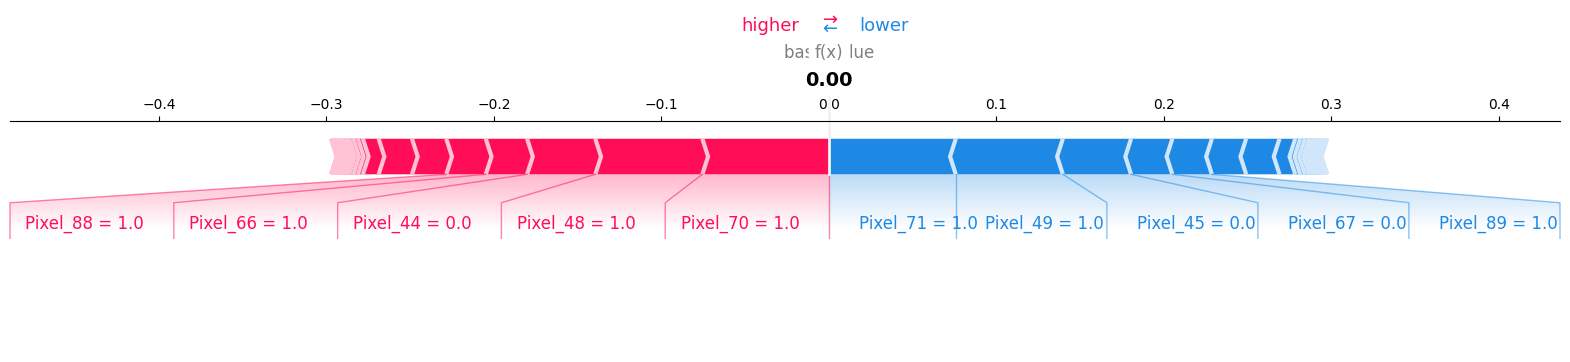

Balanced Accuracy: 94.94%

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.92      0.95    250436
      Attack       0.74      0.98      0.84     60593

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029



In [11]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns

class ModelEvaluator:
    def __init__(self, model_path, param):
        """Initialize the evaluator with model and parameters"""
        self.model = load_model(model_path)
        self.param = param
        self.results_dir = param["res"]
        os.makedirs(self.results_dir, exist_ok=True)
        
    def load_test_data(self):
        """Load and prepare test data"""
        try:
            return self._load_preprocessed_data()
        except FileNotFoundError:
            return self._process_raw_data()
    
    def _load_preprocessed_data(self):
        """Load preprocessed test data from pickle files"""
        test_pickle_path = self.param["dir"] + f'test_{self.param["Max_A_Size"]}x{self.param["Max_B_Size"]}_{"MI" if self.param["mutual_info"] else "Mean"}.pickle'
        test_labels_path = self.param["dir"] + "YTest.pickle"
        
        with open(test_pickle_path, 'rb') as f:
            X_test = pickle.load(f)
        with open(test_labels_path, 'rb') as f:
            y_test = pd.read_pickle(f)
            
        X_test = np.array(X_test)
        image_size1, image_size2 = X_test.shape[1], X_test.shape[2]
        X_test = np.reshape(X_test, (-1, image_size1, image_size2, 1))
        
        return X_test, y_test
    
    def _process_raw_data(self):
        """Process raw test data from CSV"""
        test_csv_path = self.param["dir"] + "Test.csv"
        test_data = pd.read_csv(test_csv_path)
        test_data.replace("", np.nan, inplace=True)
        test_data.dropna(inplace=True)
        
        y_test = test_data[" classification."].astype(int)
        X_test = test_data.drop(" classification.", axis=1).values
        
        # Normalize data
        test_max, test_min = X_test.max(), X_test.min()
        X_test = (X_test - test_min) / (test_max - test_min)
        
        # Convert to image format using Cart2Pixel
        _, image_model, _ = Cart2Pixel(
            {"data": X_test.T, "method": self.param["Metod"], 
             "max_A_size": self.param["Max_A_Size"], 
             "max_B_size": self.param["Max_B_Size"]},
            self.param["Max_A_Size"],
            self.param["Max_B_Size"],
            self.param["Dynamic_Size"],
            mutual_info=self.param["mutual_info"],
            params=self.param
        )
        
        X_test = np.array([
            ConvPixel(
                X_test[:, i],
                np.array(image_model["xp"]),
                np.array(image_model["yp"]),
                image_model["A"],
                image_model["B"],
                custom_cut=image_model.get("custom_cut")
            ) for i in range(X_test.shape[1])
        ])
        
        return X_test, y_test
    
    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        predictions_prob = self.model.predict(X_test, verbose=1)
        predictions = np.argmax(predictions_prob, axis=1)
        
        metrics = {
            'accuracy': balanced_accuracy_score(y_test, predictions),
            'confusion_matrix': confusion_matrix(y_test, predictions),
            'classification_report': classification_report(y_test, predictions, 
                                                        target_names=["Normal", "Attack"]),
            'predictions': predictions,
            'probabilities': predictions_prob
        }
        
        return metrics
    
    def _generate_force_plot(self, shap_results):
        """Generate and save SHAP force plot"""
        shap.initjs()
        
        # Get the SHAP values for the predicted class
        predicted_class = shap_results['predicted_class']
        
        # Handle the case where shap_values is a list of arrays (one per class)
        if isinstance(shap_results['shap_values'], list):
            shap_values = shap_results['shap_values'][predicted_class]
        else:
            shap_values = shap_results['shap_values']
        
        # Get original shapes
        print(f"Original SHAP values shape: {shap_values.shape}")
        print(f"Original sample shape: {shap_results['sample'].shape}")
        
        # Reshape preserving the correct dimensions
        # If SHAP values are (1, 10, 10, 2), reshape to (100,)
        shap_values_flat = shap_values.reshape(-1)[:100]  # Take first 100 values
        sample_flat = shap_results['sample'].reshape(-1)[:100]  # Take first 100 values
        
        print(f"Reshaped SHAP values shape: {shap_values_flat.shape}")
        print(f"Reshaped sample shape: {sample_flat.shape}")
        
        # Create feature names matching the actual number of features
        feature_names = [f"Pixel_{i}" for i in range(len(sample_flat))]
        
        try:
            force_plot = shap.force_plot(
                base_value=shap_results['expected_values'][predicted_class],
                shap_values=shap_values_flat,
                features=sample_flat,
                feature_names=feature_names,
                matplotlib=True
            )
            
            plt.figure(figsize=(20, 3))
            plt.tight_layout()
            plt.savefig(os.path.join(self.results_dir, 'force_plot.png'), 
                    bbox_inches='tight', 
                    dpi=300)
            plt.close()
            
        except Exception as e:
            print(f"Error in force plot generation: {str(e)}")
            print(f"Final shapes - SHAP values: {shap_values_flat.shape}, "
                f"Features: {sample_flat.shape}")
            print(f"Base value shape: {shap_results['expected_values'][predicted_class].shape}")

    def generate_shap_explanation(self, X_test, num_background=100):
        """Generate SHAP values for model explanation"""
        background = X_test[:num_background]
        explainer = shap.GradientExplainer(self.model, background)
        
        # Select random sample
        random_idx = np.random.choice(X_test.shape[0], 1, replace=False)
        X_sample = X_test[random_idx]
        
        # Print shapes for debugging
        print(f"X_sample shape: {X_sample.shape}")
        
        # Generate SHAP values
        shap_values = explainer.shap_values(X_sample)
        print(f"Generated SHAP values shape: {np.array(shap_values).shape}")
        
        predictions = self.model.predict(X_sample)
        predicted_class = np.argmax(predictions, axis=1)[0]
        expected_values = np.mean(self.model.predict(background), axis=0)
        
        return {
            'shap_values': shap_values,
            'sample': X_sample,
            'expected_values': expected_values,
            'sample_idx': random_idx[0],
            'predicted_class': predicted_class
        }
    def visualize_results(self, metrics, shap_results):
        """Create and save visualizations"""
        # 1. Confusion Matrix Heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(metrics['confusion_matrix'], 
                    annot=True, 
                    fmt='d', 
                    cmap='Blues',
                    xticklabels=["Normal", "Attack"],
                    yticklabels=["Normal", "Attack"])
        plt.title('Confusion Matrix')
        plt.savefig(os.path.join(self.results_dir, 'confusion_matrix.png'))
        plt.close()
        try:
        # 2. SHAP Image Plot
            shap.image_plot(shap_results['shap_values'], 
                        shap_results['sample'],
                        show=False)
            plt.savefig(os.path.join(self.results_dir, 'shap_explanation.png'))
            plt.close()
        except Exception as e:
          print(f"Error generating SHAP image plot: {str(e)}")
        try:
        # 3. Feature Contributions Analysis
            self._analyze_feature_contributions(shap_results['shap_values'],
                                            shap_results['sample'])
        except Exception as e:
            print(f"Error analyzing feature contributions: {str(e)}")
        try:
            self._generate_force_plot(shap_results)
        except Exception as e:
            print(f"Error generating force plot: {str(e)}")
    def _analyze_feature_contributions(self, shap_values, sample):
        """Analyze and save feature contributions"""
        shap_values_flat = shap_values[0].flatten()
        contributions = [(f"Pixel_{i}", value) for i, value in enumerate(shap_values_flat)]
        
        # Sort contributions
        positive_contributions = sorted(
            [(f, v) for f, v in contributions if v > 0],
            key=lambda x: x[1],
            reverse=True
        )
        negative_contributions = sorted(
            [(f, v) for f, v in contributions if v < 0],
            key=lambda x: x[1]
        )
        
        # Save to file
        with open(os.path.join(self.results_dir, 'feature_contributions.txt'), 'w') as f:
            f.write("Top Positive Contributions:\n")
            for feature, value in positive_contributions[:10]:
                f.write(f"{feature}: {value:.4f}\n")
            
            f.write("\nTop Negative Contributions:\n")
            for feature, value in negative_contributions[:10]:
                f.write(f"{feature}: {value:.4f}\n")
    
    

# Usage
if __name__ == "__main__":
    # Your parameter setup here
    param = {
        "Max_A_Size": 10,
        "Max_B_Size": 10,
        "Dynamic_Size": False,
        'Metod': 'tSNE',
        "ValidRatio": 0.1,
        "seed": 180,
        "dir": "D:/IDS/Datasets/",
        "res": "D:/IDS/Results/",
        "Mode": "CNN2",
        "LoadFromJson": True,
        "mutual_info": True,
        "hyper_opt_evals": 20,
        "epoch": 150,
        "No_0_MI": False,
        "autoencoder": False,
        "cut": None,
        "enhanced_dataset": None
    }
    
    best_model_path = "D:/IDS/Datasets/AAGM/best_model.keras"
    
    # Initialize evaluator
    evaluator = ModelEvaluator(best_model_path, param)
    
    # Load and evaluate
    X_test, y_test = evaluator.load_test_data()
    metrics = evaluator.evaluate_model(X_test, y_test)
    
    # Generate explanations
    shap_results = evaluator.generate_shap_explanation(X_test)
    
    # Create visualizations
    evaluator.visualize_results(metrics, shap_results)
    # Print results
    print(f"Balanced Accuracy: {metrics['accuracy']*100:.2f}%")
    print("\nClassification Report:\n", metrics['classification_report'])

Model Precision Improvement


In [16]:
# New cell for improving precision
print("Analyzing and improving model precision...")

import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report
from tensorflow.keras.models import load_model

# First load the model
model = load_model(best_model_path)

# Convert lists to numpy arrays
XTestGlobal = np.array(XTestGlobal)
YTestGlobal = np.array(YTestGlobal)

# Print shapes to debug
print("XTestGlobal shape:", XTestGlobal.shape)
print("YTestGlobal shape:", YTestGlobal.shape)
print("XTestGlobal type:", type(XTestGlobal))
print("YTestGlobal type:", type(YTestGlobal))

# Reshape if needed
if len(XTestGlobal.shape) == 3:
    XTestGlobal = XTestGlobal.reshape(-1, XTestGlobal.shape[1], XTestGlobal.shape[2], 1)

def find_optimal_threshold(model, X_test, y_test):
    """Find the best threshold that maximizes precision while keeping good recall"""
    # Get model predictions
    print("Making predictions...")
    y_pred_proba = model.predict(X_test, verbose=1)
    print("Prediction shape:", y_pred_proba.shape)
    
    # Calculate precision-recall curve
    print("Calculating precision-recall curve...")
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
    
    # Find optimal threshold
    valid_indices = recalls >= 0.90
    valid_precisions = precisions[valid_indices]
    valid_thresholds = thresholds[valid_indices[:-1]]
    
    if len(valid_thresholds) > 0:
        optimal_idx = np.argmax(valid_precisions)
        return valid_thresholds[optimal_idx]
    return 0.5

def evaluate_with_threshold(model, X_test, y_test, threshold=0.5):
    """Evaluate model with custom threshold"""
    y_pred_proba = model.predict(X_test, verbose=1)
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    print(f"\nResults with threshold {threshold}:")
    print(classification_report(y_test, y_pred))
    return y_pred

try:
    # Find and apply optimal threshold
    print("\nFinding optimal threshold...")
    optimal_threshold = find_optimal_threshold(model, XTestGlobal, YTestGlobal)
    print(f"\nOptimal threshold found: {optimal_threshold}")
    
    print("\nEvaluating with optimal threshold...")
    y_pred_optimal = evaluate_with_threshold(model, XTestGlobal, YTestGlobal, optimal_threshold)
except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nDetailed error information:")
    import traceback
    traceback.print_exc()

Analyzing and improving model precision...
XTestGlobal shape: (0,)
YTestGlobal shape: (0,)
XTestGlobal type: <class 'numpy.ndarray'>
YTestGlobal type: <class 'numpy.ndarray'>

Finding optimal threshold...
Making predictions...
Error occurred: math domain error

Detailed error information:


d:\IDS\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Traceback (most recent call last):
  File "C:\Users\arnav\AppData\Local\Temp\ipykernel_16408\3275366095.py", line 57, in <module>
    optimal_threshold = find_optimal_threshold(model, XTestGlobal, YTestGlobal)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\arnav\AppData\Local\Temp\ipykernel_16408\3275366095.py", line 29, in find_optimal_threshold
    y_pred_proba = model.predict(X_test, verbose=1)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\IDS\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  Fil

In [3]:
import pickle
import numpy as np
import pandas as pd

def analyze_training_samples(param):
    """
    Analyzes the number of samples in XTrain50%A pickle file and their class distribution
    Normal samples are labeled as 0, Attack samples are labeled as 1
    
    Parameters:
    param (dict): Dictionary containing directory and other parameters
    
    Returns:
    tuple: Total samples, number of normal samples (0), number of attack samples (1)
    """
    try:
        # Load the training data
        with open(param["dir"] + 'XTrain50A%.pickle', 'rb') as f:
            X_train = pickle.load(f)
        
        with open(param["dir"] + 'YTrain50A%.pickle', 'rb') as f:
            y_train = pickle.load(f)
            
        # Convert to numpy array if not already
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Get total number of samples
        total_samples = len(X_train)
        
        # Count samples specifically for class 0 (normal) and 1 (attack)
        normal_samples = np.sum(y_train == 0)
        attack_samples = np.sum(y_train == 1)
        
        # Verify that all samples are accounted for
        if normal_samples + attack_samples != total_samples:
            print("Warning: Found samples with labels other than 0 and 1")
            print(f"Unaccounted samples: {total_samples - (normal_samples + attack_samples)}")
        
        # Create a detailed summary
        print("\nSample Distribution Analysis:")
        print("-" * 50)
        print(f"Total number of samples: {total_samples}")
        print("\nClass Distribution:")
        print(f"Normal (Label 0): {normal_samples} samples ({(normal_samples/total_samples)*100:.2f}%)")
        print(f"Attack (Label 1): {attack_samples} samples ({(attack_samples/total_samples)*100:.2f}%)")
        
        # Print imbalance ratio
        imbalance_ratio = max(normal_samples, attack_samples) / min(normal_samples, attack_samples)
        print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
        
        return total_samples, normal_samples, attack_samples
        
    except FileNotFoundError:
        print("Error: Could not find the pickle files. Please check the directory path.")
        return None, None, None
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return None, None, None

# Parameters
param = {
    "dir": "D:/IDS/Datasets/AAGM/",  # Update this path to match your directory
    "Max_A_Size": 10,
    "Max_B_Size": 10,
}

# Run the analysis
total, normal_count, attack_count = analyze_training_samples(param)

if total is not None:
    print("\nData Shape Information:")
    print("-" * 50)
    print(f"X_train shape: ({total}, {param['Max_A_Size']}, {param['Max_B_Size']})")


Sample Distribution Analysis:
--------------------------------------------------
Total number of samples: 547351

Class Distribution:
Normal (Label 0): 396743 samples (72.48%)
Attack (Label 1): 150608 samples (27.52%)

Class Imbalance Ratio: 2.63:1

Data Shape Information:
--------------------------------------------------
X_train shape: (547351, 10, 10)


In [4]:
import csv
import numpy as np

def analyze_training_samples_csv(file_path):
    """
    Analyzes the number of samples and class distribution from a CSV file.
    Normal samples are labeled as 0, Attack samples are labeled as 1.
    
    Args:
        file_path (str): Path to the CSV file.
     
    Returns:
        tuple: Total samples, number of normal samples (0), number of attack samples (1)
    """
    try:
        # Initialize counters
        total_samples = 0
        normal_samples = 0
        attack_samples = 0
        
        # Read the CSV file
        with open(file_path, 'r') as file:
            # Create CSV reader
            csv_reader = csv.DictReader(file)
            
            # Count samples
            for row in csv_reader:
                total_samples += 1
                # Check the classification label
                if row[' classification'] == '0':
                    normal_samples += 1
                elif row[' classification'] == '1':
                    attack_samples += 1
        
        # Verify that all samples are accounted for
        if normal_samples + attack_samples != total_samples:
            print("Warning: Found samples with labels other than 0 and 1")
            print(f"Unaccounted samples: {total_samples - (normal_samples + attack_samples)}")
        
        # Create a detailed summary
        print("\nSample Distribution Analysis:")
        print("-" * 50)
        print(f"Total number of samples: {total_samples}")
        print("\nClass Distribution:")
        print(f"Normal (Label 0): {normal_samples} samples ({(normal_samples/total_samples)*100:.2f}%)")
        print(f"Attack (Label 1): {attack_samples} samples ({(attack_samples/total_samples)*100:.2f}%)")
        
        # Calculate and print imbalance ratio
        if min(normal_samples, attack_samples) > 0:
            imbalance_ratio = max(normal_samples, attack_samples) / min(normal_samples, attack_samples)
            print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
        else:
            print("\nOne class has zero samples. Imbalance ratio cannot be calculated.")
        
        return total_samples, normal_samples, attack_samples
        
    except FileNotFoundError:
        print(f"Error: Could not find the CSV file at {file_path}")
        return None, None, None
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return None, None, None

# File path
file_path = "D:/IDS/Datasets/Train.csv"

# Run the analysis
total, normal_count, attack_count = analyze_training_samples_csv(file_path)

if total is not None:
    print("\nAnalysis Complete.")


Sample Distribution Analysis:
--------------------------------------------------
Total number of samples: 494021

Class Distribution:
Normal (Label 0): 396743 samples (80.31%)
Attack (Label 1): 97278 samples (19.69%)

Class Imbalance Ratio: 4.08:1

Analysis Complete.


In [5]:
import pandas as pd

# Path to the pickle file
pickle_file_path = 'D:\IDS\Datasets\YTest.pickle'

# Load the pickle file as a DataFrame
data = pd.read_pickle(pickle_file_path)

# View the first few rows
print(data.head())

# Get an overview of the DataFrame
print(data.info())


0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
Name:  classification., dtype: float64
<class 'pandas.core.series.Series'>
Index: 311029 entries, 0 to 311028
Series name:  classification.
Non-Null Count   Dtype  
--------------   -----  
311029 non-null  float64
dtypes: float64(1)
memory usage: 4.7 MB
None


In [ ]:
pip install shap


In [7]:
import json
import os
import gzip
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pickle
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE, ADASYN
import pandas as pd
import csv
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Parameters
param = {
    "Max_A_Size": 10, "Max_B_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE',
    "ValidRatio": 0.1, "seed": 180,
    "dir": "D:/IDS/Datasets/", "Mode": "CNN2",  # Mode: CNN_Nature, CNN2
    "res": "D:/IDS/Results/",  # Remote path for saving data
    "LoadFromJson": False, "mutual_info": True,  # LoadFromJson: True -> load preprocessed pickle files
    "hyper_opt_evals": 20, "epoch": 150, "No_0_MI": False,  # True -> Remove features with 0 MI
    "autoencoder": False, "cut": None, "enhanced_dataset": None  # gan, smote, adasyn, None
}

dataset = 3  # Change dataset (train and test file paths depend on this value)
if dataset == 1:
    train_file = 'TrainOneCls.csv'
    test_file = 'Test.csv'
    classif_label = 'Classification'
elif dataset == 2:
    train_file = 'Train.csv'
    test_file = 'Test_UNSW_NB15.csv'
    classif_label = 'classification'
elif dataset == 3:
    train_file = 'Train.csv'
    test_file = 'Test.csv'
    classif_label = 'classification'  # Update based on the actual dataset
elif dataset == 4:
    train_file = 'AAGMTrain_OneClsNumeric.csv'
    test_file = 'AAGMTest_OneClsNumeric.csv'
    classif_label = 'classification'
elif dataset == 5:
    train_file = 'kddcup.data.gz'
    test_file = 'corrected.gz'
    classif_label = 'label'

# Reading and Preprocessing Dataset from .gz
data = {}
if not param["LoadFromJson"]:
    # Read `.gz` files into pandas DataFrame
    #with gzip.open(param["dir"] + train_file, 'rt') as file:
    with open(param["dir"] + train_file, 'rt') as file:
        df_train = pd.read_csv(file)

    #with gzip.open(param["dir"] + test_file, 'rt') as file:
    with open(param["dir"] + test_file, 'rt') as file:
        df_test = pd.read_csv(file)

    # Split features and labels
    data["Xtrain"] = df_train.drop(columns=[classif_label])  # Features
    data["Classification"] = df_train[classif_label]         # Labels for multi-class classification

    data["Xtest"] = df_test.drop(columns=[classif_label])    # Features
    data["Ytest"] = df_test[classif_label]                   # Labels for multi-class classification

    # Save `Ytrain` and `Ytest` as pickle files
    with open("Ytrain_Multi.pickle", 'wb') as f:
        pickle.dump(data["Classification"], f, protocol=pickle.HIGHEST_PROTOCOL)

    with open("Ytest_Multi.pickle", 'wb') as f:
        pickle.dump(data["Ytest"], f, protocol=pickle.HIGHEST_PROTOCOL)

    # Oversampling using SMOTE or ADASYN (if enabled)
    if param["enhanced_dataset"] == "smote":
        sm = SMOTE(random_state=42)
        data["Xtrain"], data["Classification"] = sm.fit_resample(data["Xtrain"], data["Classification"])
    elif param["enhanced_dataset"] == "adasyn":
        ada = ADASYN(random_state=42)
        data["Xtrain"], data["Classification"] = ada.fit_resample(data["Xtrain"], data["Classification"])

    # OPTIONAL: Apply autoencoder (if enabled)
    if param["autoencoder"]:
        autoencoder = load_model(param["dir"] + 'Autoencoder.h5')
        encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encod2').output)

        # Encode train and test features
        encoded_train = encoder.predict(data["Xtrain"])
        data["Xtrain"] = pd.DataFrame(encoded_train).add_prefix('feature_')

        encoded_test = encoder.predict(data["Xtest"])
        data["Xtest"] = pd.DataFrame(encoded_test).add_prefix('feature_')

else:
    # Load preprocessed data from pickle files
    with open(param["dir"] + 'train_images.pickle', 'rb') as f:
        data["Xtrain"] = pickle.load(f)

    with open(param["dir"] + 'YTrain.pickle', 'rb') as f:
        data["Classification"] = pickle.load(f)

    with open(param["dir"] + 'test_images.pickle', 'rb') as f:
        data["Xtest"] = pickle.load(f)

    with open(param["dir"] + 'YTest.pickle', 'rb') as f:
        data["Ytest"] = pickle.load(f)

# Call train_norm function for training
model = train_norm(param, data, norm=False)


KeyError: "[' classification'] not found in axis"